In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

import implicit
import lightfm
import warnings
from validation_prepare import *
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

C:\Users\yabom\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
pd.set_option('display.max_columns',100)

DATA_PATH = '../okko/orig_data'
PREPARED_PATH = './prepared_data/'

In [3]:
actions = pd.read_pickle(PREPARED_PATH+'actions_one_table.pkl')

actions.sort_index(inplace = True) # На всякий случай, иначе деление не будет работать

actions.head()

action consumption_mode  \
user_uid element_uid ts                                     
0        51          4.416546e+07  watch                S   
         72          4.375829e+07  watch                S   
         207         4.371904e+07  watch                S   
         209         4.377814e+07  watch                S   
         434         4.338109e+07  watch                S   

                                   device_manufacturer  device_type  rating  \
user_uid element_uid ts                                                       
0        51          4.416546e+07                 99.0          0.0     NaN   
         72          4.375829e+07                 99.0          0.0     NaN   
         207         4.371904e+07                 99.0          0.0     NaN   
         209         4.377814e+07                 99.0          0.0     NaN   
         434         4.338109e+07                 99.0          0.0     NaN   

                                   watched_time  duration  type  
user_uid element_uid ts                                          
0        51          4.416546e+07       12382.0      3600     1  
         72          4.375829e+07        5653.0      6000     1  
         207         4.371904e+07        2646.0      5400     1  
         209         4.377814e+07        6971.0      7200     1  
         434         4.338109e+07        5894.0      6600     1

In [4]:
idx = get_train_test(actions)

6558458
2186152
2186153


In [5]:
actions.iloc[idx[0]].index.get_level_values(2).max()

43362401.96226887

In [6]:
actions.iloc[idx[1]].index.get_level_values(2).min()

43362401.97085199

In [7]:
actions.iloc[idx[1]].index.get_level_values(2).max()

43828341.47903843

In [8]:
actions.iloc[idx[2]].index.get_level_values(2).min()

43828341.48519237

In [9]:
actions.consumption_mode.value_counts()

S    8296227
P     873834
R     472951
Name: consumption_mode, dtype: int64

In [10]:
#actions.sort_index(level = [0,2,1],inplace = True)

In [11]:
# Вроде не пересекается.
train,test,valid = actions.iloc[idx[0]],actions.iloc[idx[1]],actions.iloc[idx[2]]

In [12]:
%%time 
dur_being_train,dur_films_train,watch_actions_train,target_train = get_target(train)
dur_being_test,dur_films_test,watch_actions_test,target_test = get_target(test)
dur_being_valid,dur_films_valid,watch_actions_valid,target_valid = get_target(valid)

Wall time: 17.9 s


In [13]:
# Получили фичи для фильмов
import pickle
with open(PREPARED_PATH+'catalogue_features.pkl','rb') as f:
    match_element_row,match_row_element,match_columns,element_matrix = pickle.load(f)
movie_match_columns = {i:ii for ii,i in enumerate(match_columns)}
movie_columns_match = {ii:i for ii,i in enumerate(match_columns)}

with open(PREPARED_PATH+'bag_of_attr_movie.pkl','rb') as f:
    bag_of_attr = pickle.load(f)

In [14]:
'''
Здесь начинается русское поле экспериментов над параметрами моделей.
'''

'\nЗдесь начинается русское поле экспериментов над параметрами моделей.\n'

In [15]:
_,_,watch_actions,_ = get_target(actions)

actions = actions.join(watch_actions['rel_dur'])
actions['rel_dur'] = actions['rel_dur'].fillna(0).replace(np.inf,1)

In [16]:
actions['action_enc'] = actions['action'].map({'watch':0,'rate':1,'bookmate':3})
actions['cons_enc'] = actions['consumption_mode'].map({'S':0,'P':1,'R':3})

In [17]:
actions.sort_index(level = [0,2,1],inplace = True)

In [18]:
#actions.reset_index()[['user_uid','element_uid']]

In [19]:
%%time
wm = actions.groupby(level = [0,1],sort = False)[['rel_dur','type','rating','action_enc','cons_enc']].mean()#.agg({'rel_dur':np.mean,'type':np.mean,'rating':np.mean,'action_enc':np.mean,})

Wall time: 5.11 s


In [20]:
wm.head()

rel_dur  type  rating  action_enc  cons_enc
user_uid element_uid                                              
0        6127         0.107821   1.0     NaN         0.0       0.0
         8168         0.025000   1.0     NaN         0.0       0.0
         1284         0.022222   1.0     NaN         0.0       0.0
         1535         0.015385   1.0     NaN         0.0       0.0
         460          0.033333   1.0     NaN         0.0       0.0

In [21]:
aa = wm.action_enc.value_counts().to_frame()
aa.columns = ['counts',]
aa['mapa'] = ['watch','bookmate','watch+rate','watch+bookmate','rate','watch+rate+bookmate','rate+bookmate']

In [22]:
wm.cons_enc.value_counts().to_frame()

,cons_enc
0.0,8296227
1.0,873834
3.0,472951


In [23]:
wm['action_enc'] = wm['action_enc'].map(aa['mapa'])
wm['cons_enc'] = wm['cons_enc'].map({0:'S',1:'P',3:'R'})

In [24]:
# Щас еще приджойним тип потребления фильма и прям ок
# И по хорошему надо бы расположить их по времени, когда их там начали потреблять
ts_df = actions.reset_index().drop_duplicates(subset = ['user_uid','element_uid'])[ ['user_uid','element_uid','ts']]

In [25]:
ts_df.set_index( ['user_uid','element_uid'],inplace = True)
ts_df.columns = ['first_ts']

In [26]:
wm = wm.join(ts_df)

In [27]:
wm.head()

rel_dur  type  rating action_enc cons_enc      first_ts
user_uid element_uid                                                          
0        6127         0.107821   1.0     NaN      watch        S  4.332506e+07
         8168         0.025000   1.0     NaN      watch        S  4.333740e+07
         1284         0.022222   1.0     NaN      watch        S  4.333743e+07
         1535         0.015385   1.0     NaN      watch        S  4.333747e+07
         460          0.033333   1.0     NaN      watch        S  4.333750e+07

In [28]:
#wm.to_pickle(PREPARED_PATH + 'u_m_feat.pkl')

In [29]:
wm['first_ts_1'] = wm['first_ts'].shift(1)

In [30]:
wm['diff_ts'] = wm['first_ts'] - wm['first_ts_1']

In [31]:
first_movie = wm.reset_index().groupby('user_uid')['element_uid'].agg(lambda x:x.iloc[0]).to_frame()
first_movie.columns = ['element_uid',]
first_movie.index.name = 'user_uid'
first_movie['ones'] = 1
first_movie.reset_index(inplace = True)
first_movie.set_index(['user_uid','element_uid'],inplace = True)


In [32]:
first_movie.head()

,,ones
user_uid,element_uid,
0,6127,1
1,1653,1
2,747,1
3,8504,1
5,813,1


In [33]:
#first_movie.index.values

In [34]:
ind_nan = wm.index.isin(first_movie.index.values)

In [35]:
#wm.diff_ts.mask(ind_nan, np.nan)
wm.ix[ind_nan,'diff_ts'] = np.nan

In [36]:
sum(ind_nan)

500000

In [37]:
#wm.head(100)

In [38]:
data_catalogue = pd.read_pickle(PREPARED_PATH+'data_catalogue.pkl')

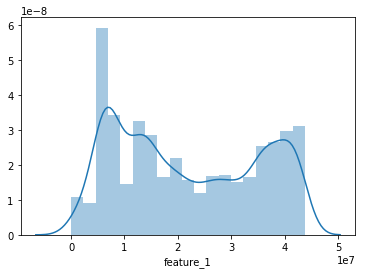

In [39]:
sns.distplot(data_catalogue.feature_1)

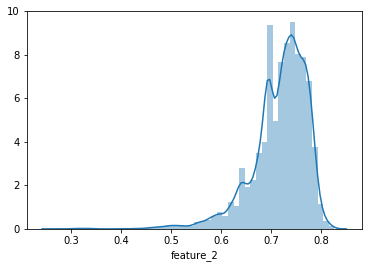

In [40]:
sns.distplot(data_catalogue.feature_2)

In [41]:
data_catalogue.feature_2.max()

0.827014415

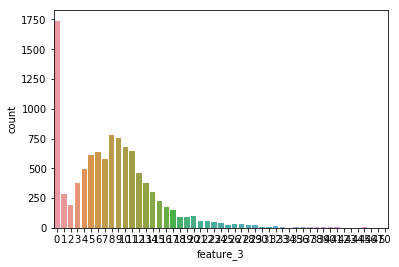

In [42]:
sns.countplot(data_catalogue.feature_3)

In [43]:
data_catalogue.feature_3.max(),data_catalogue.feature_3.min()
# Похоже на счетчик просмотров.


(50, 0)

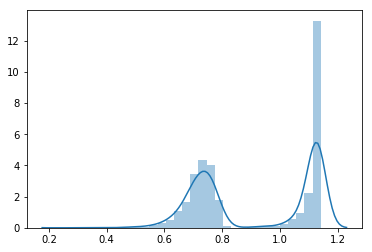

In [44]:
sns.distplot([*data_catalogue.feature_4,*data_catalogue.feature_2])

In [45]:
data_catalogue.feature_4.max(),data_catalogue.feature_4.min()

(1.1419293948, 0.7343941096)

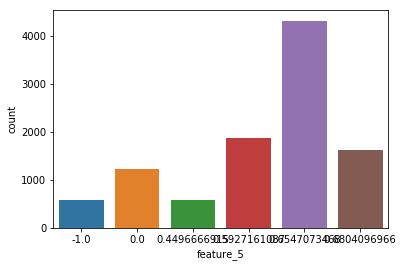

In [46]:
sns.countplot(data_catalogue.feature_5)

In [47]:
sum(data_catalogue.feature_5.value_counts().index)

1.3774998435999999

In [48]:
#sns.distplot(wm.diff_ts.dropna())

In [49]:
# Из чатика мы узнали, что вероятнее всего 184 дня приходится на трейн
#(actions.index.get_level_values(2).max() - actions.index.get_level_values(2).min())/184//1000
nearly_day = 14000

In [50]:
data_catalogue.index.name = 'element_uid'

In [51]:
wm = wm.join(data_catalogue[['duration','feature_1','feature_2','feature_3','feature_4','feature_5',]])#.loc[0,'diff_ts'].hist()

In [52]:
begin_ts = actions.index.get_level_values(2).min()
end_ts = actions.index.get_level_values(2).max()

In [53]:
#wm['feature_2'].hist()
wm[wm.first_ts < wm.feature_1]
# feature_1 - это видимо время премьеры.
# Значит можем ориентироваться, насколько есть старые фильмым
# Давайте тогда гденить в топе рекомендовать то, что добавлено в избранное и является новинкоц
# а то, что новинка сунем с понижающим коэффициентом, наверное...хотя
wm['is_history'] = 1*(wm['feature_1']<begin_ts)
wm['is_future'] = 1*(wm['feature_1']> end_ts)



In [54]:
wm['is_history'].value_counts()

1    8417853
0    1985471
Name: is_history, dtype: int64

In [55]:
wm['is_future'].value_counts()

0    10403324
Name: is_future, dtype: int64

In [56]:
#Странно, потому что вроде как у них просто получается не дошли руки до свроего же избранного
# Или типа там именно избранное, а не жду с нетерпением


In [57]:
wm['diff_novice_ts'] = (wm['feature_1'] - wm['first_ts'])//14000//365

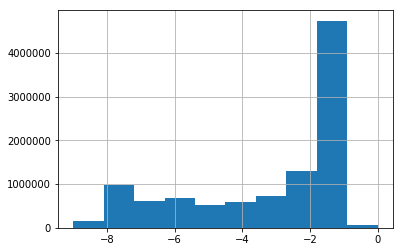

In [58]:
wm.diff_novice_ts.hist()

In [59]:
# Это не дата премьеры, это дата, когда кино появилось на платформе, ну или там стало доступно для просмотра.год основания okko 2011


In [60]:
wm['diff_ts'] = wm['diff_ts'].shift(-1)

In [61]:
wm.loc[3].head(70)

,rel_dur,type,rating,action_enc,cons_enc,first_ts,first_ts_1,diff_ts,duration,feature_1,feature_2,feature_3,feature_4,feature_5,is_history,is_future,diff_novice_ts
element_uid,,,,,,,,,,,,,,,,,
8504,0.961282,1.0,NaN,watch,S,4.210874e+07,4.394648e+07,14503.524713,130,2.647621e+07,0.749293,18,1.133525,0.654707,1,0,-4.0
8771,0.046460,3.0,NaN,watch,S,4.212325e+07,4.210874e+07,263110.278374,50,4.161910e+07,0.786378,2,1.138604,0.654707,1,0,-1.0
1380,1.007500,1.0,NaN,watch+bookmate,P,4.238636e+07,4.212325e+07,1374.008900,80,4.185697e+07,0.666559,7,1.140273,0.654707,0,0,-1.0
8756,0.012229,3.0,NaN,watch,S,4.238773e+07,4.238636e+07,40840.549895,60,4.191462e+07,0.740500,14,1.141929,0.654707,0,0,-1.0
8282,0.000000,1.0,NaN,bookmate,NaN,4.242857e+07,4.238773e+07,37.085575,90,4.231875e+07,0.694978,7,1.140273,0.680410,0,0,-1.0
4205,0.116892,3.0,NaN,watch+bookmate,S,4.242861e+07,4.242857e+07,1879.749099,50,4.221105e+07,0.692949,12,1.141929,0.680410,0,0,-1.0
4710,1.275000,1.0,NaN,watch,P,4.243049e+07,4.242861e+07,166433.855744,110,3.735914e+07,0.763761,9,1.119409,0.654707,1,0,-1.0
9307,0.008929,1.0,NaN,watch,S,4.259692e+07,4.243049e+07,286.651577,140,2.049842e+07,0.768318,14,1.133525,0.654707,1,0,-5.0
4473,0.015556,1.0,NaN,watch,S,4.259721e+07,4.259692e+07,369.505772,90,4.200169e+07,0.648004,9,1.141929,0.654707,0,0,-1.0


In [62]:
# Хочу приделать каждому фильму число просмотров и каждому пользователю тоже
# uf = wm.groupby(level = 0).agg({'rating':np.mean,'duration':len}).rename(columns = {'rating':'mean_rating_user','duration':'num_watched_user'})
mf = wm.groupby(level = 1).agg({'rating':np.mean,'duration':len}).rename(columns = {'rating':'mean_rating_movie','duration':'num_watched_movie'})

# _, bins = np.histogram(wm['rel_dur'])
# # g = sns.FacetGrid(wm, hue="feature_5",)
# # g = g.map(sns.distplot, "rel_dur", bins=bins,ax = ax)
# for i in np.unique(wm["feature_5"].values):
#     fig,ax = plt.subplots(figsize = (10,10))
#     sns.distplot(wm.loc[wm.feature_5 == i,'rel_dur'],bins = bins)

In [63]:
# wm.feature_2.corr(wm.mean_rating_movie)
#np.correlate(wm.feature_2,wm.mean_rating_movie,)

In [64]:
# A = wm.corr()

In [65]:
# sns.heatmap(A)

In [66]:
#  Ниче непонятно, давайте попробуем просто посчитать уточненное потребление
# меньше половины, если фильм
# Меньше 3 если сериал
# и если быстро начал искать новое - точно не потребил.быстро - например, меньше, чем через несколько часов
wm['target'] = 1*(((wm['type'] == 1)& (wm['rel_dur']>=0.5)) | 
                  ((wm['type'] == 3)& (wm['rel_dur']>=1/3)) | 
                (wm.action_enc.str.contains('bookmate')))

In [67]:
uf = wm.groupby(level = 0).agg({'rating':np.mean,'duration':len,'target':np.mean}).rename(columns = {'rating':'mean_rating_user','duration':'num_watched_user','target':'mean_target_user'})
mf = wm.groupby(level = 1).agg({'rating':np.mean,'duration':len,'target':np.mean}).rename(columns = {'rating':'mean_rating_movie','duration':'num_watched_movie','target':'mean_target_movie'})

In [68]:
wm = wm.join(uf)
wm = wm.join(mf)

In [69]:
wm['target'] = wm['target'].replace(0,-1)

In [70]:
wm.head(70)

rel_dur  type  rating action_enc cons_enc  \
user_uid element_uid                                               
0        6127         0.107821   1.0     NaN      watch        S   
         8168         0.025000   1.0     NaN      watch        S   
         1284         0.022222   1.0     NaN      watch        S   
         1535         0.015385   1.0     NaN      watch        S   
         460          0.033333   1.0     NaN      watch        S   
         7190         0.946515   1.0     NaN      watch        S   
         8183         0.360333   1.0     NaN      watch        S   
         1983         0.858571   1.0     NaN      watch        S   
         6272         0.841667   1.0     NaN      watch        S   
         1016         1.020000   1.0     NaN      watch        S   
         1165         0.510000   1.0     NaN      watch        S   
         5035         0.957037   1.0     NaN      watch        S   
         434          0.893030   1.0     NaN      watch        S   
         6961         1.001042   1.0     NaN      watch        S   
         10150        0.985556   1.0     NaN      watch        S   
         3651         1.222000   1.0     NaN      watch        S   
         2081         0.802222   1.0     NaN      watch        S   
         2429         0.001436   3.0     NaN      watch        S   
         4290         0.425417   1.0     NaN      watch        S   
         2570         0.890185   1.0     NaN      watch        S   
         2143         0.801833   1.0     NaN      watch        S   
         4972         0.000000   1.0     NaN      watch        S   
         944          0.067037   1.0     NaN      watch        S   
         5366         1.453333   1.0     NaN      watch        S   
         2651         0.918333   1.0     NaN      watch        S   
         3567         0.861500   1.0     NaN      watch        S   
         5039         0.512037   1.0     NaN      watch        S   
         3722         0.961500   1.0     NaN      watch        S   
         9175         0.250833   1.0     NaN      watch        S   
         3496         0.200417   1.0     NaN      watch        S   
...                        ...   ...     ...        ...      ...   
         5003         1.226042   1.0     NaN      watch        S   
         207          0.490000   1.0     NaN      watch        S   
         4300         0.000289   3.0     NaN      watch        S   
         2462         0.000000   1.0     NaN      watch        S   
         893          0.874697   1.0     NaN      watch        S   
         5644         2.650000   1.0     NaN      watch        S   
         72           0.942167   1.0     NaN      watch        S   
         8612         0.941167   1.0     NaN      watch        S   
         5840         0.054697   1.0     NaN      watch        S   
         7733         0.111111   1.0     NaN      watch        S   
         209          0.968194   1.0     NaN      watch        S   
         1253         0.069232   3.0     NaN      watch        S   
         6887         0.823333   1.0     NaN      watch        S   
         3260         0.858333   1.0     NaN      watch        S   
         8679         0.000000   1.0     NaN      watch        S   
         1176         1.001667   1.0     NaN      watch        S   
         6687         1.924000   1.0     NaN      watch        S   
         9443         0.651389   1.0     NaN      watch        S   
         4047         0.935741   1.0     NaN      watch        S   
         3595         0.400238   1.0     NaN      watch        S   
         4948         0.033333   1.0     NaN      watch        S   
         2245         0.928939   1.0     NaN      watch        S   
         3582         0.958519   1.0     NaN      watch        S   
         9351         0.935139   1.0     NaN      watch        S   
         1911         0.254848   1.0     NaN      watch        S   
         2439         0.801389   1.0     NaN      watch        S   
         88

In [71]:
wm.to_pickle(PREPARED_PATH+'some_wm.pkl')

In [ ]:
# Надо как-то формалт=изовать зашло не зашло.
# Например, ситуация - человек сел, посмотрел мало (т.е. не зашло, а значит перебирает сколько то фильмов пока не найдет тот, который зайдет)
# , захотел смотреть больше и подряд.
# Можно вычислить сначала такие последовательности, а потом критическое время просмотра в минутах.


In [ ]:
'''
Здесь заканчиваетс/ русское поле экспериментов
'''

In [ ]:
actions.head()

In [ ]:
#Проверим, что не загибается на полном датасете

fe = FeatureExtractor({'movie_attr_matrix':element_matrix,'movie_match_columns':movie_match_columns,
                       'movie_columns_match':movie_columns_match,'movie_match_row_movie':match_row_element,
                      'movie_match_movie_row':match_element_row,},bag_of_attr,mode = 'duration',delimiter = 1/3,
                     target_col_name = 'rel_dur',)


# fe = FeatureExtractor({'movie_attr_matrix':element_matrix,'movie_match_columns':movie_match_columns,
#                        'movie_columns_match':movie_columns_match,'movie_match_row_movie':match_row_element,
#                       'movie_match_movie_row':match_element_row,},bag_of_attr,is_censor = False)
X = fe.fit_transform(actions)

In [ ]:
cfe = ColdFeatureExtractor(fe)

res_action = cfe.fit_transform(actions)

In [ ]:
res_action.keys()

In [ ]:
len(fe.train_movie_match_movie_row),len(fe.match_user_row)

In [ ]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

In [ ]:
X_user = res_action['train_user']
X_movie = res_action['train_movie']
X_user.shape,X_movie.shape

In [ ]:
# def fit_lightfm(train,item_features=None,seed = 0)
seed = 0
epochs = 30
num_threads=4

model = lightfm.LightFM(loss = 'warp',random_state=seed)


# model.fit(train_matrix,user_features = train_user,item_features = element_matrix,epochs = epochs,num_threads = num_threads,
#          verbose = True)


In [ ]:


%time model.fit(X,user_features=X_user,item_features=X_movie,epochs = epochs,num_threads = num_threads,verbose = True)

In [ ]:
%%time
a,b = X.nonzero()
D = pd.DataFrame([a,b],index = ['row','columns']).T
D = D.groupby('row').agg(lambda x:frozenset(x.values))
D

In [ ]:
D.loc[1]

In [ ]:
len(fe.train_movie_match_row_movie)

In [ ]:
print('sparsity',X.nnz/(X.shape[0]*X.shape[1]))

In [ ]:
len( set(test_users) - set(fe.match_user_row.keys()))

In [ ]:
from implicit.nearest_neighbours import TFIDFRecommender,CosineRecommender,NearestNeighboursScorer



In [ ]:
# Для implicit  надо фильмы*юзеры матрицу.
# model = CosineRecommender()
# model.fit(X.T.tocsr())

In [ ]:
#ratings_matrix_T.shape

In [ ]:
# Сделаем какой-нибудь сабмит из lightfm
result = {}
mode = 'lightfm'#'implicit'#'lightfm'
cnt = 0
for user_uid in tqdm.tqdm(test_users):
    
    # transform user_uid to model's internal user category
    try:
        user_cat = fe.match_user_row[user_uid]
    except LookupError:
        continue
    if mode == 'lightfm':
        need_cols = np.array(list(set(np.arange(X.shape[1])) - D.get(user_cat, set())))
        recs = model.predict(user_cat,need_cols,user_features=X_user,item_features=X_movie,num_threads=num_threads)
        need_movies = np.argsort(-recs)[:20]
        result[user_uid] = [int(fe.train_movie_match_row_movie[i]) for i in need_movies]
    # переводим в фильмы
    
    # perform inference
    if mode == 'implicit':
        if cnt == 0:
            ratings_matrix_T = X.T.tocsr()
        recs = model.recommend(
            user_cat,
            X.tocsr(),
            N=20,
            filter_already_liked_items=True,
            filter_items=D.get(user_uid, set())
        )
        result[user_uid] = [int(fe.train_movie_match_row_movie[i]) for i, _ in recs]
        # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    cnt += 1

In [ ]:
user_cat

In [ ]:
len(fe.train_movie_match_row_movie)

In [ ]:
recs

In [ ]:
#len(need_cols),len(recs),type(recs)

In [ ]:
#plt.hist(recs)

In [ ]:
len(result)

In [ ]:

with open('answer.json', 'w') as f:
    json.dump(result, f)

In [ ]:
te.shape

In [ ]:
from lightfm.evaluation import auc_score,precision_at_k

# Compute and print the AUC score
train_auc = precision_at_k(model, te ,tr, k = 20,num_threads=4).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

In [ ]:
new_old_tr_te_2.keys()

In [ ]:
tr = new_old_tr_te_2['train_interactions']
te = new_old_tr_te_2['test_interactions']
uf = new_old_tr_te_2['user_features_train']
tf = new_old_tr_te_2['user_features_test']
print(tr.shape,te.shape,uf.shape,tf.shape)
# tr[(tr < 3) &  (tr>0)] = -1
# tr[(tr > 3)] = 1
# te[(tr < 3) &  (te>0)] = -1
# te[(tr > 3)] = 1

model.fit(train_matrix,user_features=uf,epochs = epochs,num_threads =num_threads,
         verbose = True)

In [ ]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [ ]:
p = model.predict(0,np.arange(tr.shape[1]),user_features=tf[0,:],num_threads=num_threads)

In [ ]:
plt.hist(p)

In [ ]:
test_user[0,:]

In [ ]:
a = model.predict(0,np.arange(train_matrix.shape[1]),user_features=test_user[0,:],num_threads=num_threads)
len(a)

In [ ]:
from lightfm.evaluation import auc_score,precision_at_k

# Compute and print the AUC score
train_auc = precision_at_k(model, train_matrix,user_features = train_user,item_features = element_matrix ,num_threads=num_threads).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

In [ ]:
model.user_feature_map

In [ ]:
def get_answer(test_users_dict,test):
    pass